# Phase 6: Visualize Complete Registration Results

This notebook provides comprehensive visualization of the complete OCT registration pipeline.

## What this shows:
- XY registration results (Phase 3 - Vessel-Enhanced method)
- Surface alignment results (Phase 5 - depth alignment)
- 3D transformation parameters
- Quality metrics and confidence scores
- **3D volume projections from multiple angles** (X, Y, Z axes + 45° view)
- Side-by-side comparison of Volume 0, Volume 1 (aligned), and Merged volume

All visualizations are **3D projections** showing the actual volumetric structure with **0% data loss** (expanded merging).

## Setup and Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from scipy.ndimage import rotate

# Setup paths (handle running from notebooks/ or root)
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    data_dir = notebook_dir / 'data'
else:
    data_dir = notebook_dir / 'notebooks' / 'data'

plt.rcParams['figure.figsize'] = (15, 10)

print("✓ Imports complete")

✓ Imports complete


In [2]:
# Load all registration data
print("Loading registration results...")

# Phase 1: Surfaces
surface_v0 = np.load(data_dir / 'surface_peaks_volume0.npy')
surface_v1 = np.load(data_dir / 'surface_peaks_volume1.npy')
surface_v1_aligned = np.load(data_dir / 'surface_v1_fully_aligned.npy')

# Phase 3: XY registration parameters
xy_params = np.load(data_dir / 'xy_registration_params.npy', allow_pickle=True).item()

# Phase 5: Complete 3D registration
registration_3d = np.load(data_dir / 'registration_3d_params.npy', allow_pickle=True).item()

print(f"✓ Loaded all data")
print(f"\nData shapes:")
print(f"  Surfaces: {surface_v0.shape}")
print(f"  Surface aligned: {surface_v1_aligned.shape}")

Loading registration results...
✓ Loaded all data

Data shapes:
  Surfaces: (1536, 360)
  Surface aligned: (1536, 360)


## 1. Display Registration Parameters

In [3]:
print("=" * 70)
print("3D REGISTRATION PARAMETERS")
print("=" * 70)
print()
print("📍 XY Registration (Phase 3):")
print(f"   Method: {xy_params.get('best_method', 'phase_correlation')}")
print(f"   Translation (X, Z): ({xy_params['offset_x']:.2f}, {xy_params['offset_z']:.2f}) pixels")
print(f"   Confidence: {xy_params['confidence']:.2f}")
print(f"   Improvement: {xy_params['improvement_percent']:.1f}%")
print()
print("📏 Depth Alignment (Phase 5):")
print(f"   Method used: {registration_3d['depth_method_used']}")
print(f"   Depth offset: {registration_3d['depth_offset_final']:.2f} pixels")
print(f"   Confidence: {registration_3d['depth_confidence_final']:.2%}")
print(f"   Surface improvement: {registration_3d['z_improvement']*100:.1f}%")
print()
print("🎯 FINAL 3D TRANSFORM:")
transform = registration_3d['transform_3d']
print(f"   X translation (lateral): {transform['dx']:.2f} pixels")
print(f"   Y translation (depth):   {transform['dy']:.2f} pixels")
print(f"   Z translation (B-scan):  {transform['dz']:.2f} pixels")
print("=" * 70)

3D REGISTRATION PARAMETERS

📍 XY Registration (Phase 3):
   Method: Vessel-Enhanced
   Translation (X, Z): (-412.00, 5.00) pixels
   Confidence: 31.16
   Improvement: 15.8%

📏 Depth Alignment (Phase 5):
   Method used: Correlation (Method B)
   Depth offset: -100.00 pixels
   Confidence: 100.00%
   Surface improvement: -0.0%

🎯 FINAL 3D TRANSFORM:
   X translation (lateral): -412.00 pixels
   Y translation (depth):   -100.00 pixels
   Z translation (B-scan):  5.00 pixels


## 2. Surface Alignment Visualization

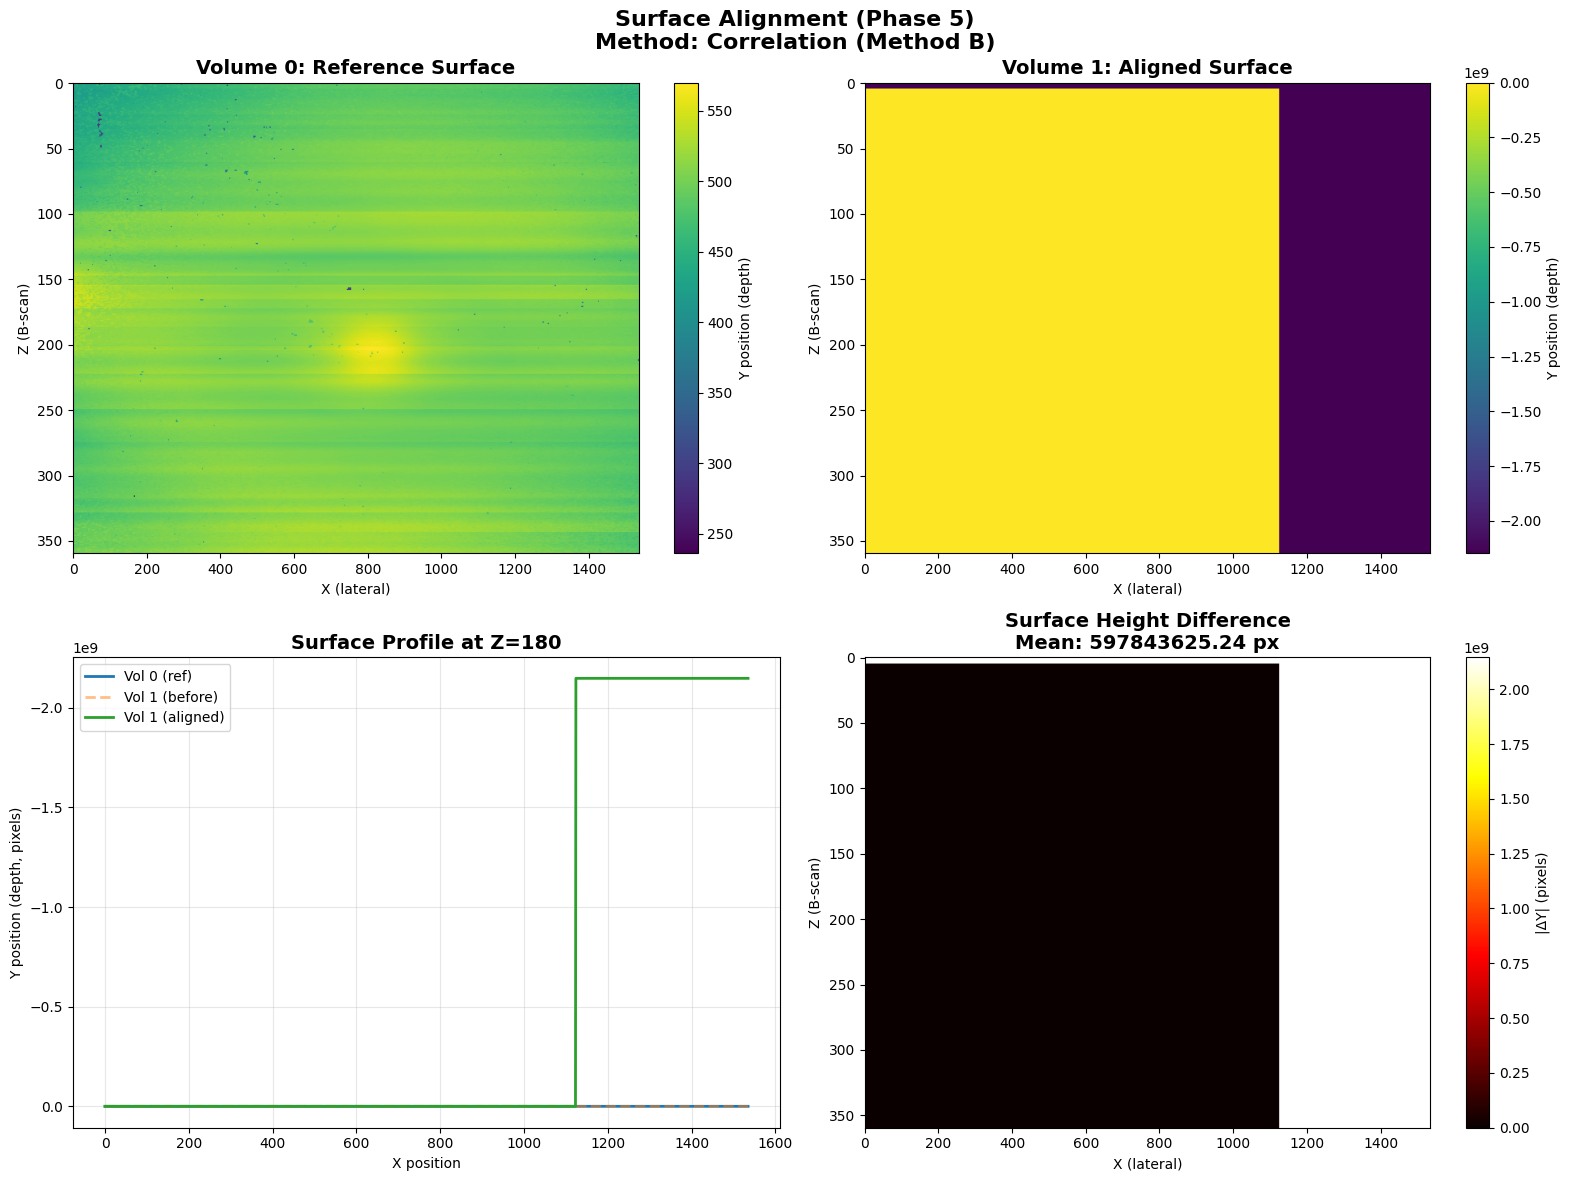


📊 Surface Alignment Quality:
  Mean difference: 597843625.24 ± 962518582.93 pixels
  Improvement: -0.0%


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Surface before alignment
im0 = axes[0, 0].imshow(surface_v0.T, aspect='auto', cmap='viridis')
axes[0, 0].set_title('Volume 0: Reference Surface', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('X (lateral)')
axes[0, 0].set_ylabel('Z (B-scan)')
plt.colorbar(im0, ax=axes[0, 0], label='Y position (depth)')

# Surface after alignment
im1 = axes[0, 1].imshow(surface_v1_aligned.T, aspect='auto', cmap='viridis')
axes[0, 1].set_title('Volume 1: Aligned Surface', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('X (lateral)')
axes[0, 1].set_ylabel('Z (B-scan)')
plt.colorbar(im1, ax=axes[0, 1], label='Y position (depth)')

# Surface profiles (middle B-scan)
mid_z = surface_v0.shape[1] // 2
axes[1, 0].plot(surface_v0[:, mid_z], label='Vol 0 (ref)', linewidth=2)
axes[1, 0].plot(surface_v1[:, mid_z], label='Vol 1 (before)', alpha=0.5, linestyle='--', linewidth=2)
axes[1, 0].plot(surface_v1_aligned[:, mid_z], label='Vol 1 (aligned)', linewidth=2)
axes[1, 0].set_xlabel('X position')
axes[1, 0].set_ylabel('Y position (depth, pixels)')
axes[1, 0].set_title(f'Surface Profile at Z={mid_z}', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].invert_yaxis()

# Difference map
diff = np.abs(surface_v0 - surface_v1_aligned)
im_diff = axes[1, 1].imshow(diff.T, aspect='auto', cmap='hot')
axes[1, 1].set_title(f'Surface Height Difference\nMean: {np.nanmean(diff):.2f} px', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('X (lateral)')
axes[1, 1].set_ylabel('Z (B-scan)')
plt.colorbar(im_diff, ax=axes[1, 1], label='|ΔY| (pixels)')

plt.suptitle(f'Surface Alignment (Phase 5)\nMethod: {registration_3d["depth_method_used"]}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Surface Alignment Quality:")
print(f"  Mean difference: {np.nanmean(diff):.2f} ± {np.nanstd(diff):.2f} pixels")
print(f"  Improvement: {registration_3d['z_improvement']*100:.1f}%")

## 3. 3D Merged Volume Visualization

Load full 3D OCT volumes, apply transformation, merge them, and visualize as **3D volume projections** from multiple angles.

The volumes are rendered as **3D scatter plots** showing the actual volumetric structure (not 2D slices).

In [5]:
import sys
sys.path.append('../src')
from oct_volumetric_viewer import OCTImageProcessor, OCTVolumeLoader
from scipy.ndimage import shift as nd_shift

print("Loading full 3D OCT volumes...")
print("This may take 1-2 minutes...")

# Initialize loader with updated cropping: 100px top, 50px bottom
processor = OCTImageProcessor(sidebar_width=250, crop_top=100, crop_bottom=50)
loader = OCTVolumeLoader(processor)

# Find volume directories containing BMP files (recursively search)
oct_data_dir = Path('../oct_data')

# Find all directories with BMP files
bmp_dirs = []
for bmp_file in oct_data_dir.rglob('*.bmp'):
    vol_dir = bmp_file.parent
    if vol_dir not in bmp_dirs:
        bmp_dirs.append(vol_dir)

# Sort to get consistent ordering
all_volume_dirs = sorted(bmp_dirs)

print(f"\nFound {len(all_volume_dirs)} volume directories with BMP files")

# Use the F001 data (same as used in notebooks 1-4)
f001_vols = [v for v in all_volume_dirs if 'F001_IP' in str(v)]

if len(f001_vols) >= 2:
    print(f"\nUsing F001 data (same as notebooks 1-4):")
    print(f"  Volume 0: {f001_vols[0].name}")
    print(f"  Volume 1: {f001_vols[1].name}")
    volume_dirs_to_use = f001_vols[:2]
else:
    print(f"\nWarning: F001 data not found, using first 2 available volumes")
    volume_dirs_to_use = all_volume_dirs[:2]

# Load volumes
print("\nLoading volume 0...")
volume_0 = loader.load_volume_from_directory(str(volume_dirs_to_use[0]))

print("Loading volume 1...")
volume_1 = loader.load_volume_from_directory(str(volume_dirs_to_use[1]))

if volume_0 is None or volume_1 is None:
    print("\n❌ ERROR: Failed to load volumes!")
    print("Make sure the directories contain BMP files.")
else:
    print(f"\n✓ Loaded volumes:")
    print(f"  Volume 0: {volume_0.shape}")
    print(f"  Volume 1: {volume_1.shape}")

2025-11-03 15:58:00,060 - INFO - Found 360 BMP files
2025-11-03 15:58:00,139 - INFO - Loading scan 1/360


Loading full 3D OCT volumes...
This may take 1-2 minutes...

Found 8 volume directories with BMP files

Using F001 data (same as notebooks 1-4):
  Volume 0: F001_IP_20250604_175814_Retina_3D_L_6mm_1536x360_2
  Volume 1: F001_IP_20250604_180102_Retina_3D_L_6mm_1536x360_2

Loading volume 0...


2025-11-03 15:58:04,076 - INFO - Loading scan 51/360
2025-11-03 15:58:07,656 - INFO - Loading scan 101/360
2025-11-03 15:58:11,118 - INFO - Loading scan 151/360
2025-11-03 15:58:14,578 - INFO - Loading scan 201/360
2025-11-03 15:58:18,193 - INFO - Loading scan 251/360
2025-11-03 15:58:21,667 - INFO - Loading scan 301/360
2025-11-03 15:58:25,152 - INFO - Loading scan 351/360
2025-11-03 15:58:25,864 - INFO - Successfully loaded volume with shape (842, 1536, 360)
2025-11-03 15:58:25,870 - INFO - Found 360 BMP files
2025-11-03 15:58:25,940 - INFO - Loading scan 1/360


Loading volume 1...


2025-11-03 15:58:30,809 - INFO - Loading scan 51/360
2025-11-03 15:58:34,265 - INFO - Loading scan 101/360
2025-11-03 15:58:37,712 - INFO - Loading scan 151/360
2025-11-03 15:58:41,157 - INFO - Loading scan 201/360
2025-11-03 15:58:44,604 - INFO - Loading scan 251/360
2025-11-03 15:58:48,082 - INFO - Loading scan 301/360
2025-11-03 15:58:51,620 - INFO - Loading scan 351/360
2025-11-03 15:58:52,316 - INFO - Successfully loaded volume with shape (842, 1536, 360)



✓ Loaded volumes:
  Volume 0: (842, 1536, 360)
  Volume 1: (842, 1536, 360)


In [6]:
# Apply 3D transformation to volume 1
print("Applying 3D transformation to volume 1...")

transform = registration_3d['transform_3d']
print(f"\nTransformation:")
print(f"  X (lateral): {transform['dx']:.2f} pixels")
print(f"  Y (depth):   {transform['dy']:.2f} pixels")
print(f"  Z (B-scan):  {transform['dz']:.2f} pixels")

# Apply shift to volume 1
# Note: scipy.ndimage.shift uses (y, x, z) order
shift_vector = (transform['dy'], transform['dx'], transform['dz'])
volume_1_aligned = nd_shift(volume_1, shift=shift_vector, order=1, mode='constant', cval=0)

print(f"\n✓ Volume 1 aligned: {volume_1_aligned.shape}")

Applying 3D transformation to volume 1...

Transformation:
  X (lateral): -412.00 pixels
  Y (depth):   -100.00 pixels
  Z (B-scan):  5.00 pixels

✓ Volume 1 aligned: (842, 1536, 360)


In [7]:
# Create EXPANDED merged volume that fits both volumes without cropping
print("Creating expanded merged volume...")

def create_expanded_merged_volume(volume_0, volume_1, transform_3d):
    """
    Create expanded volume that fits both volumes without data loss.
    
    Args:
        volume_0: Reference volume (h, w, d)
        volume_1: Volume to merge (h, w, d)
        transform_3d: {'dy': Y_offset, 'dx': X_offset, 'dz': Z_offset}
    
    Returns:
        expanded_volume: Merged volume with NO data loss
        metadata: Information about the merge
    """
    h, w, d = volume_0.shape
    dy, dx, dz = int(transform_3d['dy']), int(transform_3d['dx']), int(transform_3d['dz'])
    
    print(f"Original volume shape: {volume_0.shape}")
    print(f"Translation: dy={dy}, dx={dx}, dz={dz}")
    
    # Calculate expanded dimensions to fit both volumes
    new_h = h + abs(dy)
    new_w = w + abs(dx)
    new_d = d + abs(dz)
    
    print(f"Expanded volume shape: ({new_h}, {new_w}, {new_d})")
    print(f"  Height increase: {abs(dy)} pixels")
    print(f"  Width increase: {abs(dx)} pixels")
    print(f"  Depth increase: {abs(dz)} B-scans")
    
    # Create expanded canvas
    expanded = np.zeros((new_h, new_w, new_d), dtype=volume_0.dtype)
    
    # Determine placement coordinates
    # If offset is positive, vol0 starts at origin; if negative, vol0 is offset
    y0_start = max(0, -dy)
    x0_start = max(0, -dx)
    z0_start = max(0, -dz)
    
    y1_start = max(0, dy)
    x1_start = max(0, dx)
    z1_start = max(0, dz)
    
    print(f"\nPlacement:")
    print(f"  Volume 0: y={y0_start}:{y0_start+h}, x={x0_start}:{x0_start+w}, z={z0_start}:{z0_start+d}")
    print(f"  Volume 1: y={y1_start}:{y1_start+h}, x={x1_start}:{x1_start+w}, z={z1_start}:{z1_start+d}")
    
    # Place volume 0
    expanded[y0_start:y0_start+h, x0_start:x0_start+w, z0_start:z0_start+d] = volume_0
    
    # Calculate overlap region
    # For each axis, find where both volumes exist
    y_overlap_start = max(y0_start, y1_start)
    y_overlap_end = min(y0_start+h, y1_start+h)
    x_overlap_start = max(x0_start, x1_start)
    x_overlap_end = min(x0_start+w, x1_start+w)
    z_overlap_start = max(z0_start, z1_start)
    z_overlap_end = min(z0_start+d, z1_start+d)
    
    has_overlap = (y_overlap_end > y_overlap_start and 
                   x_overlap_end > x_overlap_start and 
                   z_overlap_end > z_overlap_start)
    
    if has_overlap:
        print(f"\nOverlap region:")
        print(f"  y: {y_overlap_start}:{y_overlap_end} ({y_overlap_end-y_overlap_start} pixels)")
        print(f"  x: {x_overlap_start}:{x_overlap_end} ({x_overlap_end-x_overlap_start} pixels)")
        print(f"  z: {z_overlap_start}:{z_overlap_end} ({z_overlap_end-z_overlap_start} B-scans)")
        
        # Blend in overlap region (50/50 average)
        # Extract overlap regions from both volumes
        v0_y = slice(y_overlap_start-y0_start, y_overlap_end-y0_start)
        v0_x = slice(x_overlap_start-x0_start, x_overlap_end-x0_start)
        v0_z = slice(z_overlap_start-z0_start, z_overlap_end-z0_start)
        
        v1_y = slice(y_overlap_start-y1_start, y_overlap_end-y1_start)
        v1_x = slice(x_overlap_start-x1_start, x_overlap_end-x1_start)
        v1_z = slice(z_overlap_start-z1_start, z_overlap_end-z1_start)
        
        overlap_v0 = volume_0[v0_y, v0_x, v0_z]
        overlap_v1 = volume_1[v1_y, v1_x, v1_z]
        
        # Blend 50/50
        blended_overlap = 0.5 * overlap_v0 + 0.5 * overlap_v1
        
        # Place blended overlap in expanded volume
        expanded[y_overlap_start:y_overlap_end, 
                x_overlap_start:x_overlap_end, 
                z_overlap_start:z_overlap_end] = blended_overlap
        
        overlap_voxels = blended_overlap.size
    else:
        print("\n⚠️  No overlap region (volumes completely separated)")
        overlap_voxels = 0
    
    # Place non-overlap regions of volume 1
    # This is tricky - we need to place volume 1 everywhere except the overlap
    # Simple approach: create mask and place
    mask_v1 = np.ones((new_h, new_w, new_d), dtype=bool)
    mask_v1[y0_start:y0_start+h, x0_start:x0_start+w, z0_start:z0_start+d] = False  # Exclude vol0 region
    
    # Place volume 1 in its position (will overwrite background, not vol0/overlap)
    v1_placed = np.zeros_like(expanded)
    v1_placed[y1_start:y1_start+h, x1_start:x1_start+w, z1_start:z1_start+d] = volume_1
    
    # Only add vol1 where mask allows (non-overlap regions)
    if has_overlap:
        # Don't overwrite overlap (already blended)
        v1_mask = (v1_placed > 0) & (expanded == 0)
        expanded[v1_mask] = v1_placed[v1_mask]
    else:
        # No overlap, just add vol1
        expanded[y1_start:y1_start+h, x1_start:x1_start+w, z1_start:z1_start+d] = volume_1
    
    # Calculate statistics
    vol0_only_voxels = np.sum((expanded > 0) & (expanded == volume_0[0,0,0]))  # Approximation
    vol1_only_voxels = (volume_1 > 0).sum() - (overlap_voxels // 2 if has_overlap else 0)
    total_voxels = (expanded > 0).sum()
    
    metadata = {
        'original_shape': (h, w, d),
        'expanded_shape': (new_h, new_w, new_d),
        'translation': (dy, dx, dz),
        'expansion': (abs(dy), abs(dx), abs(dz)),
        'has_overlap': has_overlap,
        'overlap_voxels': overlap_voxels,
        'total_voxels': total_voxels,
        'data_loss': 0  # No data loss with expanded merging!
    }
    
    return expanded, metadata

# Create expanded merged volume
merged_volume, merge_metadata = create_expanded_merged_volume(volume_0, volume_1, transform)

print(f"\n✓ Merged volume created: {merged_volume.shape}")
print(f"\n📊 Merge statistics:")
print(f"  Original size: {merge_metadata['original_shape']}")
print(f"  Expanded size: {merge_metadata['expanded_shape']}")
print(f"  Overlap voxels: {merge_metadata['overlap_voxels']:,}")
print(f"  Total voxels: {merge_metadata['total_voxels']:,}")
print(f"  Data loss: {merge_metadata['data_loss']}% ✅ (No cropping!)")

if merge_metadata['has_overlap']:
    overlap_percent = 100 * merge_metadata['overlap_voxels'] / merge_metadata['total_voxels']
    print(f"  Overlap: {overlap_percent:.1f}% of total volume")

Creating expanded merged volume...
Original volume shape: (842, 1536, 360)
Translation: dy=-100, dx=-412, dz=5
Expanded volume shape: (942, 1948, 365)
  Height increase: 100 pixels
  Width increase: 412 pixels
  Depth increase: 5 B-scans

Placement:
  Volume 0: y=100:942, x=412:1948, z=0:360
  Volume 1: y=0:842, x=0:1536, z=5:365

Overlap region:
  y: 100:842 (742 pixels)
  x: 412:1536 (1124 pixels)
  z: 5:360 (355 B-scans)

✓ Merged volume created: (942, 1948, 365)

📊 Merge statistics:
  Original size: (842, 1536, 360)
  Expanded size: (942, 1948, 365)
  Overlap voxels: 296,072,840
  Total voxels: 612,485,731
  Data loss: 0% ✅ (No cropping!)
  Overlap: 48.3% of total volume


Creating 3D volume projections from multiple angles...
This shows the merged 3D volume as actual 3D projections, not 2D slices
Volume shape: (942, 1948, 365) (depth, height, width)
Subsampled to: (236, 487, 92)
Intensity threshold: 72.0
Rendering 2,881,692 voxels...

1. Creating X-axis view (sagittal)...
2. Creating Y-axis view (coronal)...
3. Creating Z-axis view (axial)...
4. Creating 45° angle view...


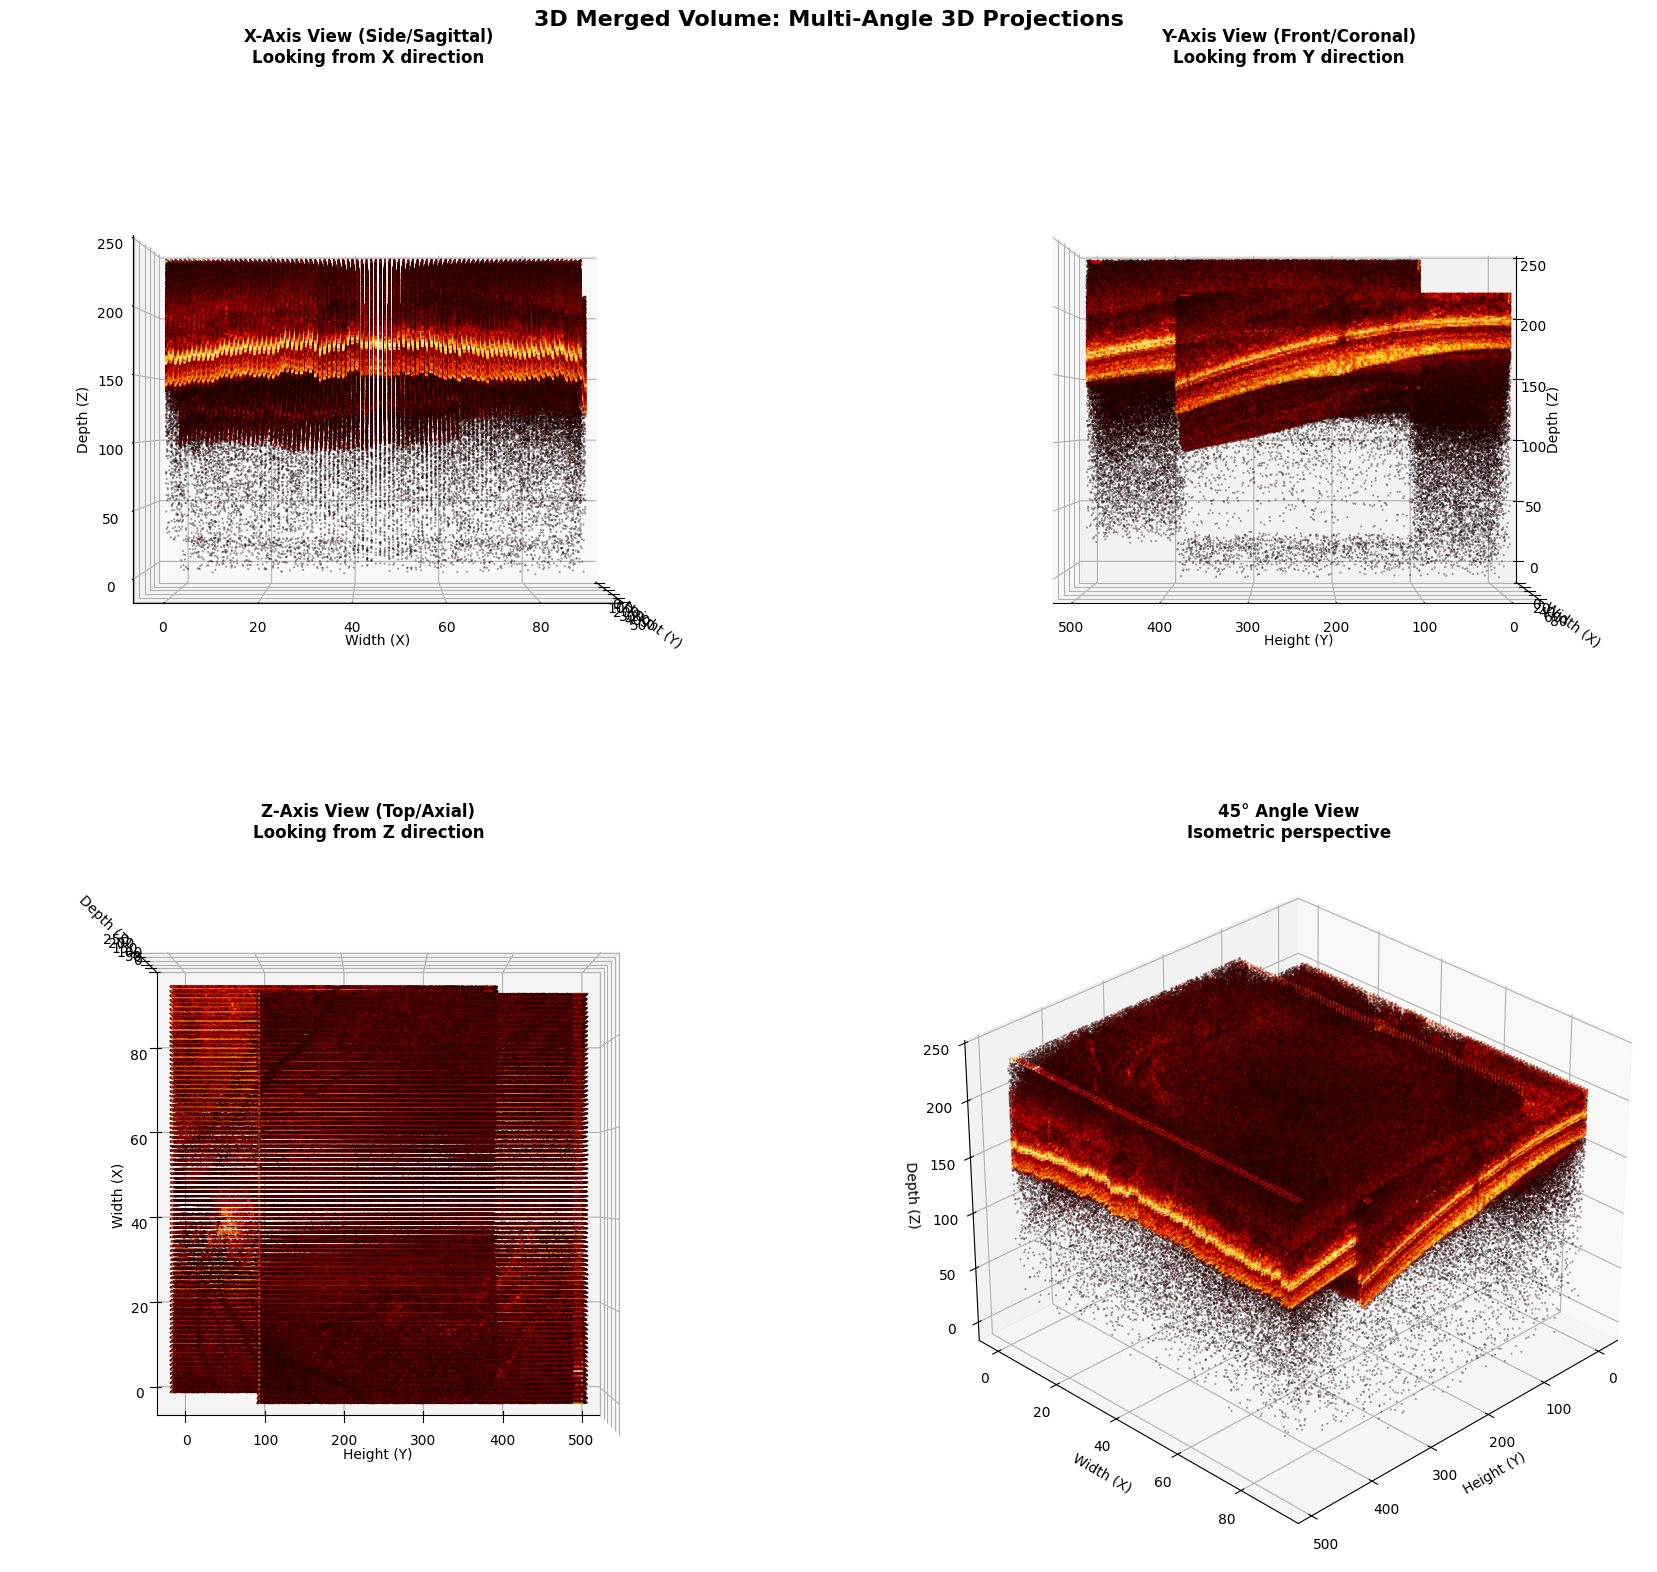


✓ 3D volume projections complete!


In [8]:
# Create 3D volume projections from multiple angles
print("Creating 3D volume projections from multiple angles...")
print("This shows the merged 3D volume as actual 3D projections, not 2D slices")

fig = plt.figure(figsize=(20, 16))

# Get volume dimensions
depth, height, width = merged_volume.shape
print(f"Volume shape: {merged_volume.shape} (depth, height, width)")

# Subsample volume for visualization (to avoid memory issues)
# Take every 4th voxel to speed up rendering
subsample = 4
vol_sub = merged_volume[::subsample, ::subsample, ::subsample]
print(f"Subsampled to: {vol_sub.shape}")

# Create threshold to show only high-intensity voxels (actual tissue)
threshold = np.percentile(vol_sub[vol_sub > 0], 70)  # Show top 30% of non-zero values
print(f"Intensity threshold: {threshold:.1f}")

# Get coordinates of voxels above threshold
z, y, x = np.where(vol_sub > threshold)
colors = vol_sub[z, y, x]

# Normalize colors for visualization
colors_norm = (colors - colors.min()) / (colors.max() - colors.min())

print(f"Rendering {len(x):,} voxels...")

# === VIEW 1: X-AXIS (Looking from side) ===
print("\n1. Creating X-axis view (sagittal)...")
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(y, x, z, c=colors_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax1.set_xlabel('Height (Y)')
ax1.set_ylabel('Width (X)')
ax1.set_zlabel('Depth (Z)')
ax1.set_title('X-Axis View (Side/Sagittal)\nLooking from X direction', fontsize=12, fontweight='bold')
ax1.view_init(elev=0, azim=0)  # Side view

# === VIEW 2: Y-AXIS (Looking from front) ===
print("2. Creating Y-axis view (coronal)...")
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter(y, x, z, c=colors_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax2.set_xlabel('Height (Y)')
ax2.set_ylabel('Width (X)')
ax2.set_zlabel('Depth (Z)')
ax2.set_title('Y-Axis View (Front/Coronal)\nLooking from Y direction', fontsize=12, fontweight='bold')
ax2.view_init(elev=0, azim=90)  # Front view

# === VIEW 3: Z-AXIS (Looking from top) ===
print("3. Creating Z-axis view (axial)...")
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(y, x, z, c=colors_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax3.set_xlabel('Height (Y)')
ax3.set_ylabel('Width (X)')
ax3.set_zlabel('Depth (Z)')
ax3.set_title('Z-Axis View (Top/Axial)\nLooking from Z direction', fontsize=12, fontweight='bold')
ax3.view_init(elev=90, azim=-90)  # Top view

# === VIEW 4: 45° ANGLE ===
print("4. Creating 45° angle view...")
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(y, x, z, c=colors_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax4.set_xlabel('Height (Y)')
ax4.set_ylabel('Width (X)')
ax4.set_zlabel('Depth (Z)')
ax4.set_title('45° Angle View\nIsometric perspective', fontsize=12, fontweight='bold')
ax4.view_init(elev=30, azim=45)  # 45 degree angle

plt.suptitle('3D Merged Volume: Multi-Angle 3D Projections', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ 3D volume projections complete!")

Creating side-by-side 3D volume comparison...
Thresholds: Vol0=73.0, Vol1=74.0, Merged=72.0
Voxel counts: Vol0=2,041,941, Vol1=1,299,570, Merged=2,881,692

Row 1: X-axis views...
Row 2: Y-axis views...
Row 3: Z-axis views...
Row 4: 45° angle views...


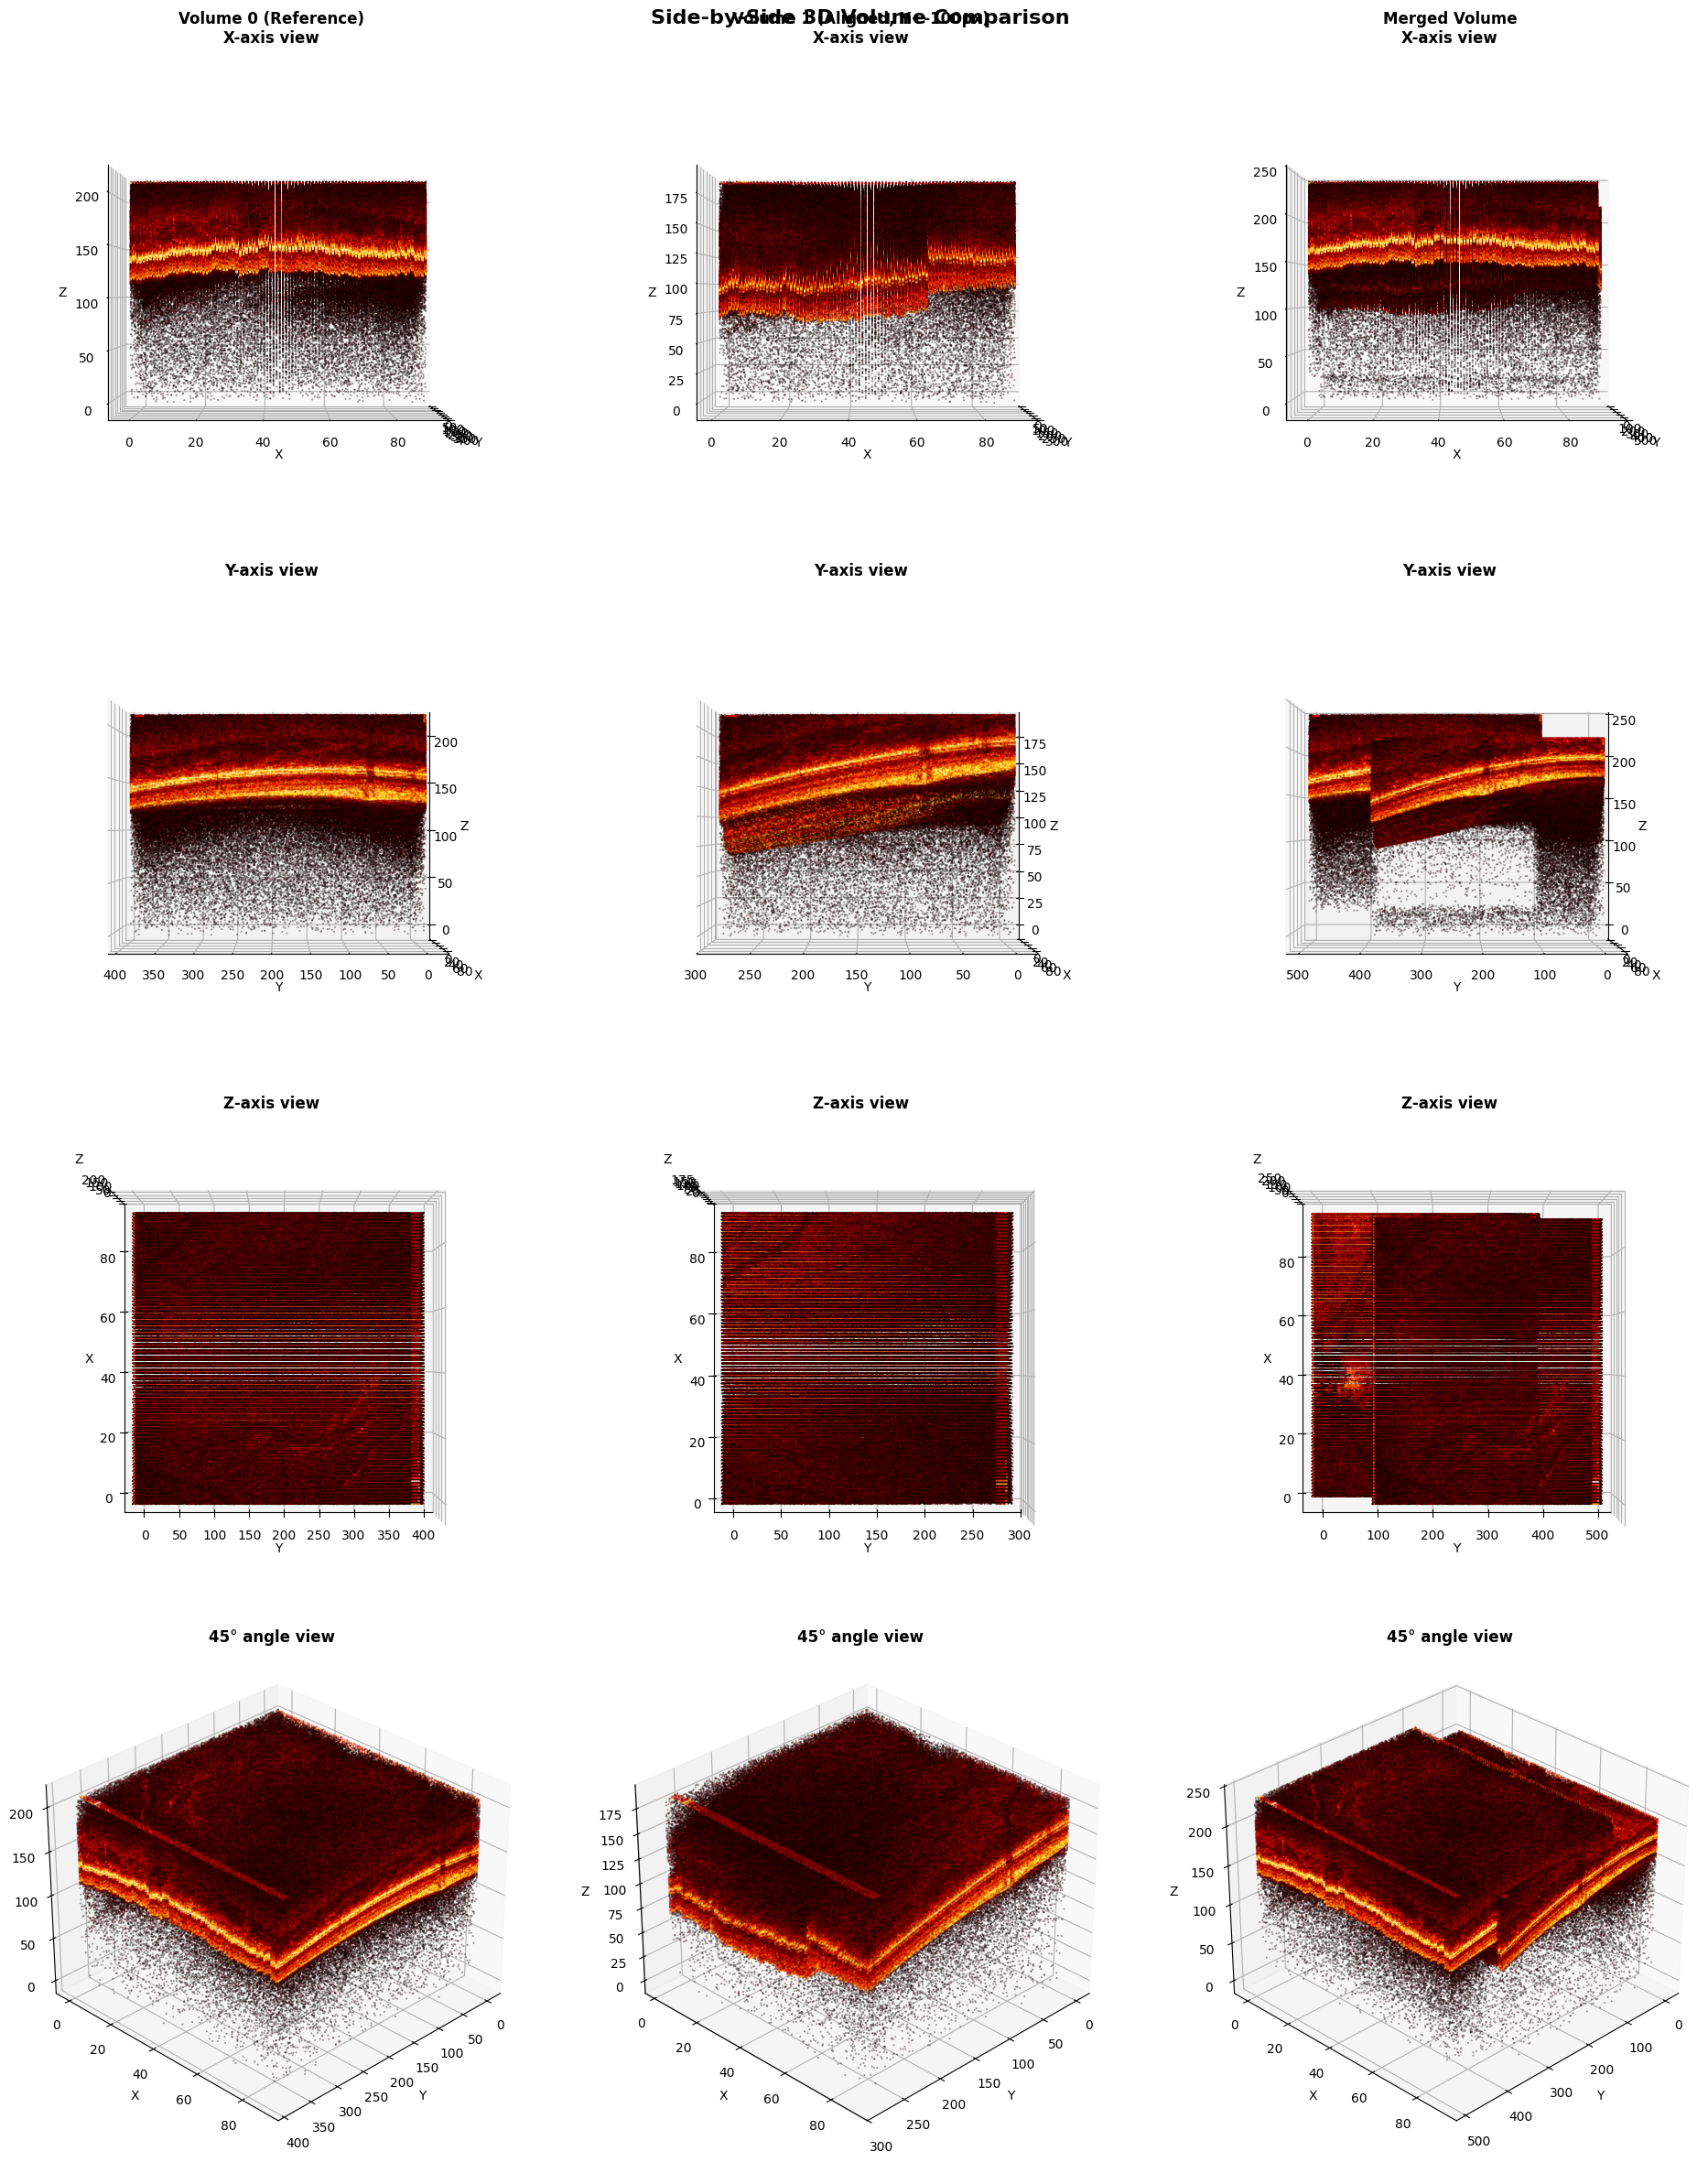


✓ Side-by-side 3D comparison complete!


In [9]:
# Side-by-side 3D comparison: Volume 0, Volume 1 (aligned), and Merged
print("Creating side-by-side 3D volume comparison...")

fig = plt.figure(figsize=(20, 24))

# Subsample all volumes
vol0_sub = volume_0[::subsample, ::subsample, ::subsample]
vol1_sub = volume_1_aligned[::subsample, ::subsample, ::subsample]
vol_merged_sub = merged_volume[::subsample, ::subsample, ::subsample]

# Get thresholds for each volume
threshold0 = np.percentile(vol0_sub[vol0_sub > 0], 70)
threshold1 = np.percentile(vol1_sub[vol1_sub > 0], 70)
threshold_merged = np.percentile(vol_merged_sub[vol_merged_sub > 0], 70)

print(f"Thresholds: Vol0={threshold0:.1f}, Vol1={threshold1:.1f}, Merged={threshold_merged:.1f}")

# Get coordinates for each volume
z0, y0, x0 = np.where(vol0_sub > threshold0)
colors0 = vol0_sub[z0, y0, x0]
colors0_norm = (colors0 - colors0.min()) / (colors0.max() - colors0.min())

z1, y1, x1 = np.where(vol1_sub > threshold1)
colors1 = vol1_sub[z1, y1, x1]
colors1_norm = (colors1 - colors1.min()) / (colors1.max() - colors1.min())

zm, ym, xm = np.where(vol_merged_sub > threshold_merged)
colors_merged = vol_merged_sub[zm, ym, xm]
colors_merged_norm = (colors_merged - colors_merged.min()) / (colors_merged.max() - colors_merged.min())

print(f"Voxel counts: Vol0={len(x0):,}, Vol1={len(x1):,}, Merged={len(xm):,}")

# Row 1: X-axis view (side)
print("\nRow 1: X-axis views...")
ax1 = fig.add_subplot(4, 3, 1, projection='3d')
ax1.scatter(y0, x0, z0, c=colors0_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax1.set_title('Volume 0 (Reference)\nX-axis view', fontweight='bold')
ax1.view_init(elev=0, azim=0)
ax1.set_xlabel('Y'); ax1.set_ylabel('X'); ax1.set_zlabel('Z')

ax2 = fig.add_subplot(4, 3, 2, projection='3d')
ax2.scatter(y1, x1, z1, c=colors1_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax2.set_title(f'Volume 1 (Aligned, Y+{transform["dy"]:.0f}px)\nX-axis view', fontweight='bold')
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Y'); ax2.set_ylabel('X'); ax2.set_zlabel('Z')

ax3 = fig.add_subplot(4, 3, 3, projection='3d')
ax3.scatter(ym, xm, zm, c=colors_merged_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax3.set_title('Merged Volume\nX-axis view', fontweight='bold')
ax3.view_init(elev=0, azim=0)
ax3.set_xlabel('Y'); ax3.set_ylabel('X'); ax3.set_zlabel('Z')

# Row 2: Y-axis view (front)
print("Row 2: Y-axis views...")
ax4 = fig.add_subplot(4, 3, 4, projection='3d')
ax4.scatter(y0, x0, z0, c=colors0_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax4.set_title('Y-axis view', fontweight='bold')
ax4.view_init(elev=0, azim=90)
ax4.set_xlabel('Y'); ax4.set_ylabel('X'); ax4.set_zlabel('Z')

ax5 = fig.add_subplot(4, 3, 5, projection='3d')
ax5.scatter(y1, x1, z1, c=colors1_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax5.set_title('Y-axis view', fontweight='bold')
ax5.view_init(elev=0, azim=90)
ax5.set_xlabel('Y'); ax5.set_ylabel('X'); ax5.set_zlabel('Z')

ax6 = fig.add_subplot(4, 3, 6, projection='3d')
ax6.scatter(ym, xm, zm, c=colors_merged_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax6.set_title('Y-axis view', fontweight='bold')
ax6.view_init(elev=0, azim=90)
ax6.set_xlabel('Y'); ax6.set_ylabel('X'); ax6.set_zlabel('Z')

# Row 3: Z-axis view (top)
print("Row 3: Z-axis views...")
ax7 = fig.add_subplot(4, 3, 7, projection='3d')
ax7.scatter(y0, x0, z0, c=colors0_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax7.set_title('Z-axis view', fontweight='bold')
ax7.view_init(elev=90, azim=-90)
ax7.set_xlabel('Y'); ax7.set_ylabel('X'); ax7.set_zlabel('Z')

ax8 = fig.add_subplot(4, 3, 8, projection='3d')
ax8.scatter(y1, x1, z1, c=colors1_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax8.set_title('Z-axis view', fontweight='bold')
ax8.view_init(elev=90, azim=-90)
ax8.set_xlabel('Y'); ax8.set_ylabel('X'); ax8.set_zlabel('Z')

ax9 = fig.add_subplot(4, 3, 9, projection='3d')
ax9.scatter(ym, xm, zm, c=colors_merged_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax9.set_title('Z-axis view', fontweight='bold')
ax9.view_init(elev=90, azim=-90)
ax9.set_xlabel('Y'); ax9.set_ylabel('X'); ax9.set_zlabel('Z')

# Row 4: 45° angle view
print("Row 4: 45° angle views...")
ax10 = fig.add_subplot(4, 3, 10, projection='3d')
ax10.scatter(y0, x0, z0, c=colors0_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax10.set_title('45° angle view', fontweight='bold')
ax10.view_init(elev=30, azim=45)
ax10.set_xlabel('Y'); ax10.set_ylabel('X'); ax10.set_zlabel('Z')

ax11 = fig.add_subplot(4, 3, 11, projection='3d')
ax11.scatter(y1, x1, z1, c=colors1_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax11.set_title('45° angle view', fontweight='bold')
ax11.view_init(elev=30, azim=45)
ax11.set_xlabel('Y'); ax11.set_ylabel('X'); ax11.set_zlabel('Z')

ax12 = fig.add_subplot(4, 3, 12, projection='3d')
ax12.scatter(ym, xm, zm, c=colors_merged_norm, cmap='hot', s=0.5, alpha=0.6, marker='.')
ax12.set_title('45° angle view', fontweight='bold')
ax12.view_init(elev=30, azim=45)
ax12.set_xlabel('Y'); ax12.set_ylabel('X'); ax12.set_zlabel('Z')

plt.suptitle('Side-by-Side 3D Volume Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Side-by-side 3D comparison complete!")

In [10]:
# Optional: Export merged volume for further analysis
print("\n" + "="*70)
print("VISUALIZATION COMPLETE!")
print("="*70)
print()
print("Optional: Save merged volume for further analysis")
print("Uncomment to save:")
print()
print("# Save as numpy array:")
print("# np.savez_compressed('data/merged_volume.npz', volume=merged_volume)")
print()
print("# Save individual volume arrays:")
print("# np.save('data/volume_0.npy', volume_0)")
print("# np.save('data/volume_1_aligned.npy', volume_1_aligned)")
print("# np.save('data/merged_volume.npy', merged_volume)")
print()
print("\n✅ All visualizations complete!")
print(f"\nMerged volume statistics:")
print(f"  Shape: {merged_volume.shape}")
print(f"  Data type: {merged_volume.dtype}")
print(f"  Value range: [{merged_volume.min():.2f}, {merged_volume.max():.2f}]")
print(f"  Memory size: {merged_volume.nbytes / 1024**2:.1f} MB")


VISUALIZATION COMPLETE!

Optional: Save merged volume for further analysis
Uncomment to save:

# Save as numpy array:
# np.savez_compressed('data/merged_volume.npz', volume=merged_volume)

# Save individual volume arrays:
# np.save('data/volume_0.npy', volume_0)
# np.save('data/volume_1_aligned.npy', volume_1_aligned)
# np.save('data/merged_volume.npy', merged_volume)


✅ All visualizations complete!

Merged volume statistics:
  Shape: (942, 1948, 365)
  Data type: float32
  Value range: [0.00, 255.00]
  Memory size: 2555.0 MB
